# Investigating the functions


In [9]:
import pandas as pd
import numpy as np
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt

f1_inp = np.load("./../function_1/initial_inputs.npy")
f1_out = np.load("./../function_1/initial_outputs.npy")
f1_out
#location

f1_inp, f1_out

(array([[0.31940389, 0.76295937],
        [0.57432921, 0.8798981 ],
        [0.73102363, 0.73299988],
        [0.84035342, 0.26473161],
        [0.65011406, 0.68152635],
        [0.41043714, 0.1475543 ],
        [0.31269116, 0.07872278],
        [0.68341817, 0.86105746],
        [0.08250725, 0.40348751],
        [0.88388983, 0.58225397]]),
 array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
         3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
        -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
         6.22985647e-048]))

# ******************************** EDA - Analysis **********************************


In [2]:
f1_inp, f1_out

(array([[0.31940389, 0.76295937],
        [0.57432921, 0.8798981 ],
        [0.73102363, 0.73299988],
        [0.84035342, 0.26473161],
        [0.65011406, 0.68152635],
        [0.41043714, 0.1475543 ],
        [0.31269116, 0.07872278],
        [0.68341817, 0.86105746],
        [0.08250725, 0.40348751],
        [0.88388983, 0.58225397]]),
 array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
         3.34177101e-124, -3.60606264e-003, -2.15924904e-054,
        -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
         6.22985647e-048]))

In [9]:
from scipy.stats import skew 

pd_inp = pd.DataFrame(f1_inp)
pd_out = pd.DataFrame(f1_out, columns=["Output"])


pd_inp.describe()
pd_out.describe()

,Output
count,1.000000e+01
mean,-3.606063e-04
std,1.140337e-03
min,-3.606063e-03
25%,-1.566820e-91
50%,6.793724e-80
75%,7.903833e-47
max,7.710875e-16


In [10]:
skew(f1_inp),skew(f1_out)

(array([-0.38584493, -0.39427118]), -2.6666666666666665)

(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 array([[<Axes: title={'center': 'Output'}>]], dtype=object))

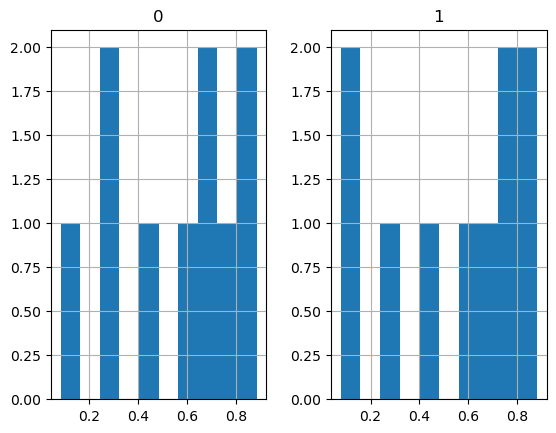

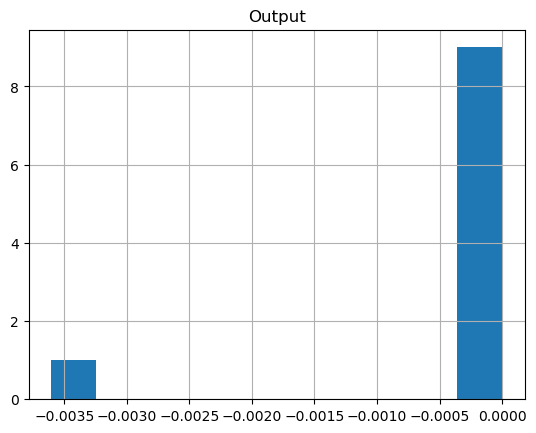

In [11]:
pd_inp.hist(), pd_out.hist()

<Axes: >

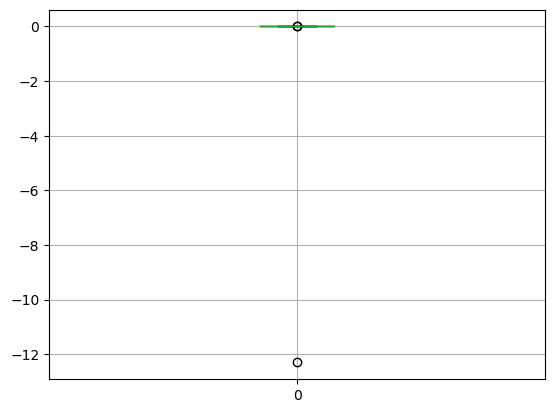

- Interesting result above, I will check the matching inputs of this datapoint 
- [0.65011406, 0.68152635] these are the mathcing inputs that give this datapoint

<Axes: >

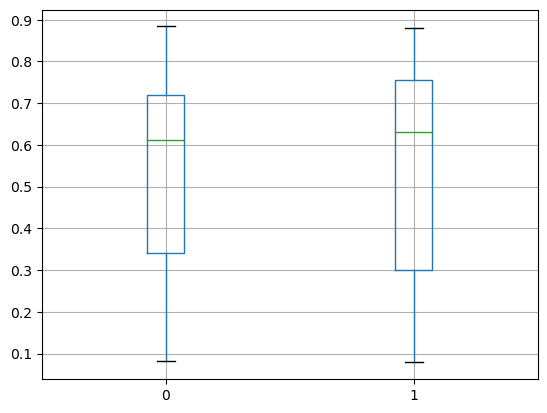

In [12]:
pd_inp.boxplot()

<Axes: >

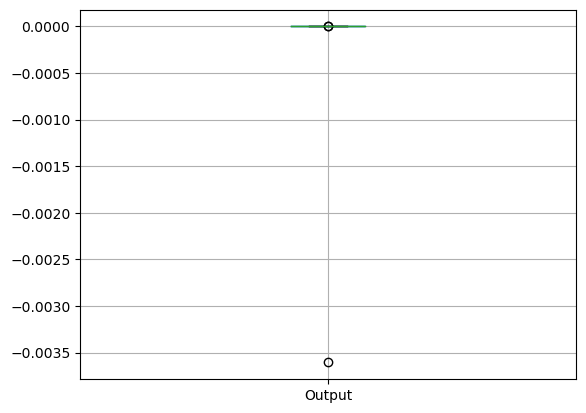

In [13]:
pd_out.boxplot()

- # Outlier dedected 
- I will think on a strategy how to benefit or avoid 

Original DataFrame:
           Output
0   1.322677e-79
1   1.033078e-46
2   7.710875e-16
3  3.341771e-124
4  -3.606063e-03
5  -2.159249e-54
6  -2.089093e-91
7   2.535001e-40
8   3.606771e-81
9   6.229856e-48

Filtered DataFrame (Outliers Removed):
           Output
0   1.322677e-79
1   1.033078e-46
3  3.341771e-124
5  -2.159249e-54
6  -2.089093e-91
8   3.606771e-81
9   6.229856e-48


<Axes: >

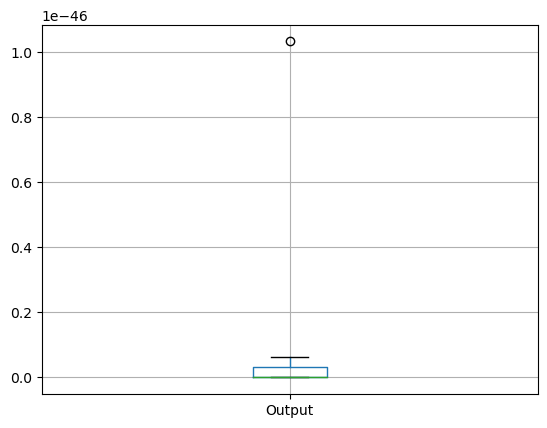

In [14]:

# Step 1: Calculate Q1, Q3, and IQR
Q1 = pd_out["Output"].quantile(0.25)  # 25th percentile
Q3 = pd_out["Output"].quantile(0.75)  # 75th percentile
IQR = Q3 - Q1                         # Interquartile range

# Step 2: Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter the DataFrame to remove outliers
pd_out_filtered = pd_out[(pd_out["Output"] >= lower_bound) & (pd_out["Output"] <= upper_bound)]

# Print the cleaned DataFrame
print("Original DataFrame:\n", pd_out)
print("\nFiltered DataFrame (Outliers Removed):\n", pd_out_filtered)
pd_out_filtered.boxplot()

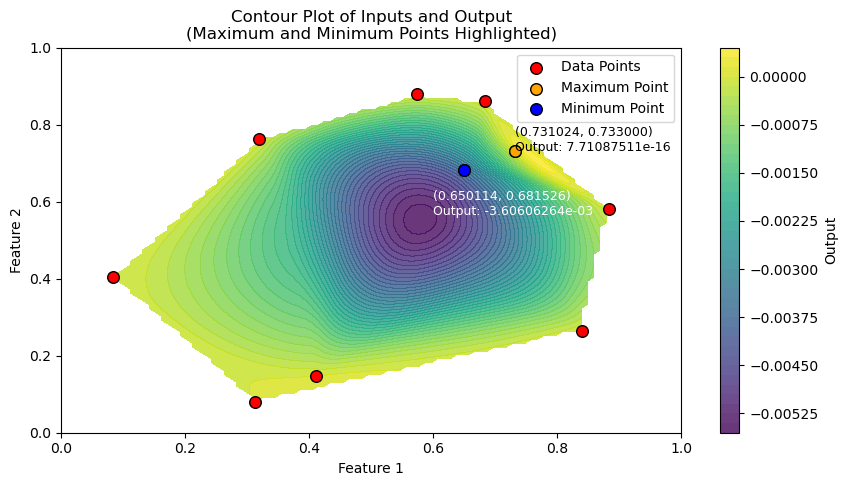

Maximum Value: 7.71087511e-16 at (x1=0.7310, x2=0.7330)
Minimum Value: -3.60606264e-03 at (x1=0.6501, x2=0.6815)


In [15]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np

# Create grid
x = f1_inp[:, 0]  # Feature 1
y = f1_inp[:, 1]  # Feature 2
z = f1_out.ravel()  # Output values
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]

# Interpolate the data for the contour plot
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

# Find the maximum output value and its corresponding input coordinates
max_idx = np.argmax(z)  # Index of the sampled point with the highest output
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]  # Coordinates and value of the max

# Find the minimum output value and its corresponding input coordinates
min_idx = np.argmin(z)  # Index of the sampled point with the lowest output
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]  # Coordinates and value of the min

# Plot
plt.figure(figsize=(10, 5))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)  # Contour plot
plt.colorbar(label="Output")
s= 70
# Scatter the sampled data points
plt.scatter(x, y, color='red', label="Data Points", edgecolor='black', s=s)

# Highlight the maximum point in orange
plt.scatter(max_x, max_y, color='orange', edgecolor='black', s=s, label="Maximum Point")
plt.text(max_x, max_y, f"({max_x:.6f}, {max_y:.6f})\nOutput: {max_z:.8e}", color='black', fontsize=9)

# Highlight the minimum point in blue
# Highlight the minimum point in blue
plt.scatter(min_x, min_y, color='blue', edgecolor='black', s=s, label="Minimum Point")
plt.text(
    min_x - 0.05,  # Shift text slightly to the left
    min_y - 0.05,  # Shift text slightly downward
    f"({min_x:.6f}, {min_y:.6f})\nOutput: {min_z:.8e}",
    color='white',
    fontsize=9,
    ha='left',  # Align text to the left
    va='top'    # Align text to the top
)

# Labels and title
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Output\n(Maximum and Minimum Points Highlighted)")
plt.legend()
plt.show()

# Print the maximum and minimum values and their coordinates
print(f"Maximum Value: {max_z:.8e} at (x1={max_x:.4f}, x2={max_y:.4f})")
print(f"Minimum Value: {min_z:.8e} at (x1={min_x:.4f}, x2={min_y:.4f})")


In [16]:
max_index_out = np.argmax(f1_out)
max_index_out
max_output = f1_out[max_index_out]

max_inp = f1_inp[max_index_out]

print(f"Best score found on index {max_index_out}")
max_inp,max_output

Best score found on index 2


(array([0.73102363, 0.73299988]), 7.710875114502849e-16)

# ***************************** Output Transformation ******************************* 
- I will use Yeo-Johnson method to hanlde the heteroscedastic nature of the data, tranform outputs, and fic asymmetric skewness. 
- Reason I am using Yeo-Johnson is because we have positive and negative values as ouput 



- Scale Factor: Compresses outliers by dividing the data, bringing extreme values closer to the main range.
- Target asinh Value: Defines the transformed range, helping to differentiate values by spreading smaller ones further apart.

In [81]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from mpmath import mp, log10, power
from scipy.stats import skew
import pandas as pd
# Preserve the signs of the original data
signs = np.sign(f1_out)

# Apply absolute to the data for log transformation
abs_data = np.abs(f1_out)

# Log transformation with mpmath applied element-wise
log_transformed_data = np.array(
    [[log10(float(x) + 1e-100)] for x in abs_data]
)

# Convert to float for MinMaxScaler
log_transformed_data_float = np.array(log_transformed_data, dtype=np.float64)

# Scale the log-transformed data
scaler = MinMaxScaler()
scaled_log_data = scaler.fit_transform(log_transformed_data_float)

# Reverse procedure
# 1. Reverse the scaling
reversed_scaled_data = scaler.inverse_transform(scaled_log_data)

# 2. Reverse log transformation with mpmath applied element-wise
recovered_abs_data = np.array(
    [[power(10, float(x)) - 1e-100] for x in reversed_scaled_data]
)

# 3. Restore the signs to the recovered data
original_data_recovered = recovered_abs_data * signs

# Print results
print("Original Data:\n", data)
print("Info Data:\n", skew(data), np.var(data))
print("")
print("Scaled Log-Transformed Data:\n", scaled_log_data)
print("Info:\n", skew(scaled_log_data), np.var(scaled_log_data))






Original Data:
 [[ 1.32267704e-079]
 [ 1.03307824e-046]
 [ 7.71087511e-016]
 [ 3.34177101e-124]
 [-3.60606264e-003]
 [-2.15924904e-054]
 [-2.08909327e-091]
 [ 2.53500115e-040]
 [ 3.60677119e-081]
 [ 6.22985647e-048]]
Info Data:
 [-2.66666667] 1.170331898724395e-06

Scaled Log-Transformed Data:
 [[0.21650365]
 [0.55366724]
 [0.87012797]
 [0.        ]
 [1.        ]
 [0.4749458 ]
 [0.09553343]
 [0.6191658 ]
 [0.20046857]
 [0.54116527]]
Info:
 [0.20619598] 0.09717255712099757


In [69]:

yeo_transformer = PowerTransformer(method='yeo-johnson')
yeo_transformed_data = yeo_transformer.fit_transform(scaled_log_data)
# Step 2: Reverse the Yeo-Johnson transformation RENOVE THIS BECASE THAT IS THE WHOLE POINT
###reversed_yeo_data = yeo_transformer.inverse_transform(yeo_transformed_data)
# 2. Reverse log transformation with mpmath applied element-wise
# recovered_abs_data = np.array(
#     [[power(10, float(x)) - 1e-100] for x in yeo_transformed_data]
# )
# 3. Restore the signs to the recovered data
# ORIGINAL_DATA_YEO_JOHNSON = yeo_transformed_data * signs
# ORIGINAL_DATA_YEO_JOHNSON
yeo_transformed_data

ValueError: operands could not be broadcast together with shapes (11,1) (10,1) 

In [85]:
f1_out

array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
        3.34177101e-124, -1.63911938e-003, -2.15924904e-054,
       -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
        6.22985647e-048])

##### Deciding if I should remove the outlier on the outputs based on Domain Knowledge about the ranges that the radiation can take. 
- I will reduce the outliers since it remains too far from the rest, it will be  ratio of the distance of the smallest values with second smallest 
- This is the only input output tranformation I will make


In [82]:

print(f1_out)
# Identify the smallest and second-smallest values
sorted_outputs = np.sort(f1_out)
smallest = sorted_outputs[0]
second_smallest = sorted_outputs[1]

# Adjust the outlier
outlier_index = np.argmin(f1_out)  # Index of the smallest value #TRACK
new_value = (second_smallest + smallest) / 2.2  # Midpoint between smallest and second-smallest
# f1_out[outlier_index] = new_value
f1_out[outlier_index] = new_value

#location
print("Updated Outputs:", f1_out)
print(f"Smallest: {smallest}, Second Smallest: {second_smallest}, New Value: {new_value}")

[ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048]
Updated Outputs: [ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -1.63911938e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048]
Smallest: -0.0036060626443634764, Second Smallest: -2.1592490357331095e-54, New Value: -0.00163911938380158


# ************************** Input Transformation************************** 
- #### First I will use the Kumaraswammy Cumulative Distribution Function to addres:

- Non Stationary nature of the function, the way way the patter in the data changes over the unput space, example, rapidly grows in some regions and slower in some other regions 
- I will use the CDF and finds its best parameters by minimising NLML(Negative Log Marginal Likelyhood)

In [63]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C, WhiteKernel
from scipy.optimize import minimize

from sklearn.preprocessing import MinMaxScaler

# Normalize the input
scaler = MinMaxScaler()
f1_inp_normalized = scaler.fit_transform(f1_inp)
np.std(f1_inp_normalized), np.std(f1_inp)
skew(f1_inp_normalized), skew(f1_inp)
f1_inp_normalized

NameError: name 'skew' is not defined

In [64]:
import numpy as np
from scipy.stats import skew
from deap import base, creator, tools, algorithms
import random
from tqdm import tqdm

# Define the warp function as before
def kumaraswamy_warp(X, a, b):
    X_clipped = np.clip(X, 1e-6, 1 - 1e-6)
    return 1 - (1 - X_clipped ** a) ** b

# Objective function
def evaluate(individual):
    a, b = individual
    X_warped = kumaraswamy_warp(f1_inp_normalized, a, b)
    variance = np.var(X_warped)
    skewness = np.mean(np.abs(skew(X_warped, axis=0)))
    return (variance + skewness,)

# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_a", random.uniform, 0.01, 2.0)
toolbox.register("attr_b", random.uniform, 0.01, 2.0)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_a, toolbox.attr_b), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize population
population = toolbox.population(n=50)

# Define number of generations
NGEN = 30
CX_PROB = 0.5
MUT_PROB = 0.2

# Statistics to keep track of progress
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run Genetic Algorithm with progress bar
for gen in tqdm(range(NGEN), desc="Genetic Algorithm Generations"):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Extract the best individual
best_ind = tools.selBest(population, k=1)[0]
best_a, best_b = best_ind
best_score = best_ind.fitness.values[0]

# Apply the best warp to the data
f1_inp_warped_best = kumaraswamy_warp(f1_inp_normalized, best_a, best_b)

# Calculate final variance and skewness
final_variance = np.var(f1_inp_warped_best)
final_skewness = np.mean(np.abs(skew(f1_inp_warped_best, axis=0)))

# Display the results
print("\n=== Best Kumaraswamy Parameters (GA) ===")
print(f"a = {best_a:.6f}")
print(f"b = {best_b:.6f}")
print(f"Combined Score (Variance + Skewness) = {best_score:.6f}")
print(f"Final Variance: {final_variance:.6f}")
print(f"Final Skewness: {final_skewness:.6f}")


Genetic Algorithm Generations: 100%|███████████████████████████████████████████████████| 30/30 [00:01<00:00, 21.83it/s]


=== Best Kumaraswamy Parameters (GA) ===
a = 0.237299
b = 0.309265
Combined Score (Variance + Skewness) = 0.090600
Final Variance: 0.066856
Final Skewness: 0.023745


In [65]:
# Apply CDF on the normalized input using the given parameters
f1_inp_warped = kumaraswamy_warp(f1_inp_normalized, a=0.237299, b=0.309265)
f1_inp, f1_inp_warped

(array([[0.31940389, 0.76295937],
        [0.57432921, 0.8798981 ],
        [0.73102363, 0.73299988],
        [0.84035342, 0.26473161],
        [0.65011406, 0.68152635],
        [0.41043714, 0.1475543 ],
        [0.31269116, 0.07872278],
        [0.68341817, 0.86105746],
        [0.08250725, 0.40348751],
        [0.88388983, 0.58225397]]),
 array([[0.34775075, 0.64002149],
        [0.49557591, 0.99106261],
        [0.60655846, 0.61174244],
        [0.73792284, 0.31600035],
        [0.54462386, 0.57001426],
        [0.40063141, 0.22343529],
        [0.34369004, 0.01181068],
        [0.56848323, 0.79847082],
        [0.01181068, 0.39888103],
        [0.99106261, 0.50288268]]))

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-09. Decreasing the bound and calling fit again may find a better value.
 C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning:The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 0.0001. Decreasing the bound and calling fit again may find a better value.

Best Parameters for the CDF : a=5.0, b=0.6444444444444445, Score=-1.652678616814196e-06


Second Guess - Best Parameters: a=0.1, b=0.1, Score=-1.6524935877874082e-06

Third Test:  Parameters: a=0.1, b=0.1, Score=-1.641027418617411e-06

Fourth Test: Best Parameters: a=0.1, b=0.6444444444444445, Score=-1.444854199452721e-06

Fifth Test: Best Parameters: a=3.911111111111112, b=5.0, Score=-1.4448627567918906e-06

In [7]:

f1_out = f1_out_transformed

#### Conclusion on Input/Output transformation: I decided to not transform input/output because if we transform just the imput it might impact the predicitions negativly, and make the model not learn a pattern.


# ***************************** Gaussian Process****************************


Optimized Kernel Parameters: 
0.0011**2 * Matern(length_scale=0.000127, nu=1.5) + WhiteKernel(noise_level=9.37e-08)

- I have tested difrent parameters of kernel and raise the bounds as per the error instrusctions to raise the bounds as we might miss some good values. 

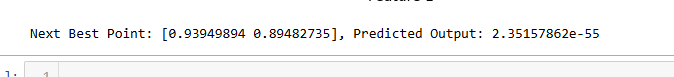

In [17]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RationalQuadratic

# Example small dataset
X = f1_inp  # Replace with your data: f1_inp
y = f1_out     # Replace with your data: f1_out

# Define more parameter ranges
length_scales = np.logspace(-6, 0, 20)  # 20 values between 1e-6 and 1
bounds_list = [(1e-6, bound) for bound in np.linspace(1, 10, 10)]  # 10 upper bounds

# Results storage
results = []

# Loop through kernels
kernels = ["Matern_nu_1.5", "Matern_nu_2.5", "RationalQuadratic"]

for kernel_name in kernels:
    for length_scale in length_scales:
        for bounds in bounds_list:
            # Create the kernel based on the current configuration
            if kernel_name == "Matern_nu_1.5":
                kernel = Matern(length_scale=length_scale, nu=1.5, length_scale_bounds=bounds)
            elif kernel_name == "Matern_nu_2.5":
                kernel = Matern(length_scale=length_scale, nu=2.5, length_scale_bounds=bounds)
            elif kernel_name == "RationalQuadratic":
                kernel = RationalQuadratic(
                    length_scale=length_scale,
                    alpha=1.0,
                    length_scale_bounds=bounds,
                    alpha_bounds=(1e-6, 10),
                )
            
            # Train Gaussian Process with the current kernel
            try:
                gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
                gp.fit(X, y)

                # Calculate Log Marginal Likelihood (LML)
                lml = gp.log_marginal_likelihood()

                # Store results
                results.append({
                    "Kernel": kernel_name,
                    "Length Scale": length_scale,
                    "Bounds": bounds,
                    "Kernel Parameters": str(kernel),
                    "LML": lml,
                })
            except Exception as e:
                # Log any errors encountered
                results.append({
                    "Kernel": kernel_name,
                    "Length Scale": length_scale,
                    "Bounds": bounds,
                    "Kernel Parameters": str(kernel),
                    "LML": None,
                    "Error": str(e),
                })

# Convert results to a pandas DataFrame for analysis
results_df = pd.DataFrame(results)

# Print results sorted by LML
results_df = results_df.sort_values(by="LML", ascending=False)
print("\nKernels sorted by Log Marginal Likelihood (LML):")
print(results_df)

# Save results to CSV for further analysis
#results_df.to_csv("kernel_lml_comparison_large.csv", index=False)


C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: Th

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 1.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: Th

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 6.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 7.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 8.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: Th

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 2.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 4.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: Th

C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 8.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 9.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\alerd\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:452: ConvergenceWarning: T

KeyboardInterrupt: 

In [30]:
results_mater = results_df[results_df["Kernel"] == "Matern_nu_1.5"]
results_mater

,Kernel,Length Scale,Bounds,Kernel Parameters,LML
79,Matern_nu_1.5,0.000162,"(1e-06, 10.0)","Matern(length_scale=0.000162, nu=1.5)",29.353083
29,Matern_nu_1.5,0.000004,"(1e-06, 10.0)","Matern(length_scale=4.28e-06, nu=1.5)",29.353083
159,Matern_nu_1.5,0.054556,"(1e-06, 10.0)","Matern(length_scale=0.0546, nu=1.5)",29.353083
149,Matern_nu_1.5,0.026367,"(1e-06, 10.0)","Matern(length_scale=0.0264, nu=1.5)",29.353083
139,Matern_nu_1.5,0.012743,"(1e-06, 10.0)","Matern(length_scale=0.0127, nu=1.5)",29.353083
...,...,...,...,...,...
150,Matern_nu_1.5,0.054556,"(1e-06, 1.0)","Matern(length_scale=0.0546, nu=1.5)",3.668389
160,Matern_nu_1.5,0.112884,"(1e-06, 1.0)","Matern(length_scale=0.113, nu=1.5)",3.668389
170,Matern_nu_1.5,0.233572,"(1e-06, 1.0)","Matern(length_scale=0.234, nu=1.5)",3.668389
180,Matern_nu_1.5,0.483293,"(1e-06, 1.0)","Matern(length_scale=0.483, nu=1.5)",3.668389


In [31]:
results_df.head(1)

,Kernel,Length Scale,Bounds,Kernel Parameters,LML
599,RationalQuadratic,1.0,"(1e-06, 10.0)","RationalQuadratic(alpha=1, length_scale=1)",42.363588


# Deciding on diffrent Kernels
- From the results above we have decided Qauadratic Kenrel with the best LML performance 

In [129]:
from tqdm import tqdm  # Import tqdm for progress bar
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel

# Example small dataset (replace with your dataset)
X = f1_inp  # Replace with your data: f1_inp
y = f1_out  # Replace with your data: f1_out

# Define parameter ranges for combinations
length_scales = np.logspace(-6, 1, 2)  # 20 values between 1e-6 and 10
alphas = np.logspace(-6, 2, 20)         # 20 values between 1e-6 and 100
noise_levels = np.logspace(-9, -3, 1)  # 10 values for noise level

# Adjust bounds for testing
bounds_list = [(1e-6, 82)]  # Bounds for length_scale

# Results storage
results = []

# Total number of iterations
total_iterations = len(length_scales) * len(alphas) * len(noise_levels) * len(bounds_list)

# Loop through parameter combinations with a progress bar
with tqdm(total=total_iterations, desc="Testing RationalQuadratic Parameters") as pbar:
    for length_scale in length_scales:
        for alpha in alphas:
            for noise_level in noise_levels:
                for bounds in bounds_list:
                    # Define RationalQuadratic kernel with WhiteKernel for noise
                    kernel = RationalQuadratic(
                        length_scale=length_scale,
                        alpha=alpha,
                        length_scale_bounds=bounds,
                        alpha_bounds=(1e-6, 100)  # Bounds for alpha
                    ) + WhiteKernel(
                        noise_level=noise_level,  # Noise level to be tested
                        noise_level_bounds=(1e-9, 1e-2)  # Bounds for noise level
                    )

                    try:
                        # Train Gaussian Process with the kernel
                        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
                        gp.fit(X, y)

                        # Calculate Log Marginal Likelihood (LML)
                        lml = gp.log_marginal_likelihood()

                        # Store results
                        results.append({
                            "Kernel": "RationalQuadratic",
                            "Length Scale": length_scale,
                            "Alpha": alpha,
                            "Noise Level": noise_level,
                            "Bounds": bounds,
                            "Kernel Parameters": str(kernel),
                            "LML": lml,
                        })
                    except Exception as e:
                        # Log errors
                        results.append({
                            "Kernel": "RationalQuadratic",
                            "Length Scale": length_scale,
                            "Alpha": alpha,
                            "Noise Level": noise_level,
                            "Bounds": bounds,
                            "Kernel Parameters": str(kernel),
                            "LML": None,
                            "Error": str(e),
                        })

                    # Update the progress bar
                    pbar.update(1)

# Convert results to a pandas DataFrame for analysis
results_df_1 = pd.DataFrame(results)

# Sort results by LML
results_df_1 = results_df_1.sort_values(by="LML", ascending=False)

# Print top results
print("\nTop Kernels by Log Marginal Likelihood (LML):")
results_df_1.head(5)
#TRACK

Testing RationalQuadratic Parameters: 100%|████████████████████████████████████████████| 40/40 [00:01<00:00, 25.56it/s]


Top Kernels by Log Marginal Likelihood (LML):


,Kernel,Length Scale,Alpha,Noise Level,Bounds,Kernel Parameters,LML
0,RationalQuadratic,0.000001,0.000001,1.000000e-09,"(1e-06, 82)","RationalQuadratic(alpha=1e-06, length_scale=1e...",49.026138
1,RationalQuadratic,0.000001,0.000003,1.000000e-09,"(1e-06, 82)","RationalQuadratic(alpha=2.64e-06, length_scale...",49.026138
22,RationalQuadratic,10.000000,0.000007,1.000000e-09,"(1e-06, 82)","RationalQuadratic(alpha=6.95e-06, length_scale...",49.026138
23,RationalQuadratic,10.000000,0.000018,1.000000e-09,"(1e-06, 82)","RationalQuadratic(alpha=1.83e-05, length_scale...",49.026138
24,RationalQuadratic,10.000000,0.000048,1.000000e-09,"(1e-06, 82)","RationalQuadratic(alpha=4.83e-05, length_scale...",49.026138


In [ ]:
# Errors have been disabled, temporary

In [123]:
results_df_1.iloc[50:]

,Kernel,Length Scale,Alpha,Noise Level,Bounds,Kernel Parameters,LML
1707,RationalQuadratic,0.000886,0.016238,4.641589e-05,"(1e-06, 82)","RationalQuadratic(alpha=0.0162, length_scale=0...",46.127054
2142,RationalQuadratic,0.004833,0.784760,2.154435e-08,"(1e-06, 82)","RationalQuadratic(alpha=0.785, length_scale=0....",46.127054
2089,RationalQuadratic,0.004833,0.002336,1.000000e-03,"(1e-06, 82)","RationalQuadratic(alpha=0.00234, length_scale=...",46.127054
822,RationalQuadratic,0.000030,0.000007,2.154435e-08,"(1e-06, 82)","RationalQuadratic(alpha=6.95e-06, length_scale...",46.127054
438,RationalQuadratic,0.000005,0.000018,2.154435e-04,"(1e-06, 82)","RationalQuadratic(alpha=1.83e-05, length_scale...",46.127054
...,...,...,...,...,...,...,...
2165,RationalQuadratic,0.004833,5.455595,2.154435e-06,"(1e-06, 82)","RationalQuadratic(alpha=5.46, length_scale=0.0...",46.127054
2166,RationalQuadratic,0.004833,5.455595,1.000000e-05,"(1e-06, 82)","RationalQuadratic(alpha=5.46, length_scale=0.0...",46.127054
2167,RationalQuadratic,0.004833,5.455595,4.641589e-05,"(1e-06, 82)","RationalQuadratic(alpha=5.46, length_scale=0.0...",46.127054
2168,RationalQuadratic,0.004833,5.455595,2.154435e-04,"(1e-06, 82)","RationalQuadratic(alpha=5.46, length_scale=0.0...",46.127054


In [118]:

# Best value 49.026138

# 46.127054
# 45.923129
# 42.363588



In [131]:
from tqdm import tqdm  # Import tqdm for progress bar
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel

# Example small dataset (replace with your dataset)
X = f1_inp  # Replace with your data: f1_inp
y = f1_out  # Replace with your data: f1_out

# Define extended parameter ranges for combinations
length_scales = np.logspace(-6, 2, 6)  # Increased to 6 values between 1e-6 and 100
alphas = np.logspace(-6, 3, 40)        # Increased to 40 values between 1e-6 and 1000
noise_levels = np.logspace(-9, -2, 5)  # Increased to 5 values between 1e-9 and 0.01

# Expanded bounds for testing
bounds_list = [
    (1e-6, 1e-1),  # Very tight bounds
    (1e-6, 1),     # Small bounds
    (1e-6, 10),    # Moderate bounds
    (1e-6, 82),    # Your original bounds
    (1e-6, 100),   # Wider bounds
    (1e-6, 500),   # Very wide bounds for exploratory purposes
    (1e-6, 1000)   # Extreme bounds for long-scale flexibility
]

# Results storage
results = []

# Total number of iterations (extended search space)
total_iterations = len(length_scales) * len(alphas) * len(noise_levels) * len(bounds_list)

# Loop through parameter combinations with a progress bar
with tqdm(total=total_iterations, desc="Extended Search for RationalQuadratic Parameters") as pbar:
    for length_scale in length_scales:
        for alpha in alphas:
            for noise_level in noise_levels:
                for bounds in bounds_list:
                    # Define RationalQuadratic kernel with WhiteKernel for noise
                    kernel = RationalQuadratic(
                        length_scale=length_scale,
                        alpha=alpha,
                        length_scale_bounds=bounds,
                        alpha_bounds=(1e-6, 1000)  # Adjusted bounds for alpha
                    ) + WhiteKernel(
                        noise_level=noise_level,  # Noise level to be tested
                        noise_level_bounds=(1e-9, 0.1)  # Broader bounds for noise level
                    )

                    try:
                        # Train Gaussian Process with the kernel
                        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
                        gp.fit(X, y)

                        # Calculate Log Marginal Likelihood (LML)
                        lml = gp.log_marginal_likelihood()

                        # Store results
                        results.append({
                            "Kernel": "RationalQuadratic",
                            "Length Scale": length_scale,
                            "Alpha": alpha,
                            "Noise Level": noise_level,
                            "Bounds": bounds,
                            "Kernel Parameters": str(kernel),
                            "LML": lml,
                        })
                    except Exception as e:
                        # Log errors
                        results.append({
                            "Kernel": "RationalQuadratic",
                            "Length Scale": length_scale,
                            "Alpha": alpha,
                            "Noise Level": noise_level,
                            "Bounds": bounds,
                            "Kernel Parameters": str(kernel),
                            "LML": None,
                            "Error": str(e),
                        })

                    # Update the progress bar
                    pbar.update(1)

# Convert results to a pandas DataFrame for analysis
results_df_2 = pd.DataFrame(results)

# Sort results by LML
results_df_2 = results_df_2.sort_values(by="LML", ascending=False)

# Print top results
print("\nTop Kernels by Log Marginal Likelihood (LML):")
results_df_2.head()


Extended Search for RationalQuadratic Parameters: 100%|████████████████████████████| 8400/8400 [14:38<00:00,  9.56it/s]


Top Kernels by Log Marginal Likelihood (LML):


,Kernel,Length Scale,Alpha,Noise Level,Bounds,Kernel Parameters,LML
2029,RationalQuadratic,0.000040,0.008377,1.000000e-02,"(1e-06, 1000)","RationalQuadratic(alpha=0.00838, length_scale=...",53.774663
7006,RationalQuadratic,100.000000,0.000001,1.000000e-09,"(1e-06, 1000)","RationalQuadratic(alpha=1e-06, length_scale=10...",53.774663
1581,RationalQuadratic,0.000040,0.000014,1.000000e-09,"(1e-06, 1000)","RationalQuadratic(alpha=1.43e-05, length_scale...",53.774663
1560,RationalQuadratic,0.000040,0.000008,3.162278e-06,"(1e-06, 1000)","RationalQuadratic(alpha=8.38e-06, length_scale...",53.774663
384,RationalQuadratic,0.000001,0.000203,1.000000e-02,"(1e-06, 1000)","RationalQuadratic(alpha=0.000203, length_scale...",53.774663


In [ ]:
#results_df_2.to_csv("optimising_kernel.csv")


RationalQuadratic(alpha=0.00838, length_scale=3.98e-05) + WhiteKernel(noise_level=0.01)


In [ ]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, WhiteKernel

# Example small dataset (replace with your dataset)
X = f1_inp  # Replace with your actual data
y = f1_out  # Replace with your actual data

# Define a fixed configuration
fixed_alpha = 0.008377
fixed_noise_level = 1e-2
fixed_length_scale = 0.000040  # Keep length scale fixed

# Define range for bounds
# Define extreme ranges for bounds
lower_bounds = np.logspace(-10, -3, 100)  # 30 values from 1e-10 to 1e-3
upper_bounds = np.logspace(1, 5, 100)     # 30 values from 10 to 100,000  # 20 values for upper bounds between 10 and 1000

# Results storage
results = []

# Total iterations
total_iterations = len(lower_bounds) * len(upper_bounds)

# Loop through bounds with a progress bar
with tqdm(total=total_iterations, desc="Testing Bounds") as pbar:
    for lower_bound in lower_bounds:
        for upper_bound in upper_bounds:
            bounds = (lower_bound, upper_bound)  # Dynamic bounds
            
            # Define RationalQuadratic kernel with varying bounds
            kernel = RationalQuadratic(
                length_scale=fixed_length_scale,
                alpha=fixed_alpha,
                length_scale_bounds=bounds,
                alpha_bounds=(1e-6, 100)  # Bounds for alpha (fixed)
            ) + WhiteKernel(
                noise_level=fixed_noise_level,
                noise_level_bounds=(1e-9, 1e-2)  # Bounds for noise level (fixed)
            )

            try:
                # Train Gaussian Process with the kernel
                gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
                gp.fit(X, y)

                # Calculate Log Marginal Likelihood (LML)
                lml = gp.log_marginal_likelihood()

                # Store results
                results.append({
                    "Kernel": "RationalQuadratic",
                    "Length Scale": fixed_length_scale,
                    "Alpha": fixed_alpha,
                    "Noise Level": fixed_noise_level,
                    "Bounds": bounds,
                    "Kernel Parameters": str(kernel),
                    "LML": lml,
                })
            except Exception as e:
                # Log errors
                results.append({
                    "Kernel": "RationalQuadratic",
                    "Length Scale": fixed_length_scale,
                    "Alpha": fixed_alpha,
                    "Noise Level": fixed_noise_level,
                    "Bounds": bounds,
                    "Kernel Parameters": str(kernel),
                    "LML": None,
                    "Error": str(e),
                })

            # Update the progress bar
            pbar.update(1)

# Convert results to a pandas DataFrame for analysis
bounds_test = pd.DataFrame(results)

# Sort results by LML
bounds_test = bounds_test.sort_values(by="LML", ascending=False)

# Print top results
print("\nTop Bounds by Log Marginal Likelihood (LML):")
bounds_test.head()

# Op


In [77]:
f1_out

array([ 1.32267704e-079,  1.03307824e-046,  7.71087511e-016,
        3.34177101e-124, -1.80303132e-003, -2.15924904e-054,
       -2.08909327e-091,  2.53500115e-040,  3.60677119e-081,
        6.22985647e-048])

In [13]:
kernel = (
    C(1.0, (1e-10, 1e3))  # Constant kernel with fixed bounds
    * RationalQuadratic(
        length_scale=0.0004,  # Optimal length scale
        alpha=1e-06,        # Optimal alpha
        length_scale_bounds=(3.43e-7, 1.0),  # Bounds based on your results
        alpha_bounds=(1e-6, 1)  # Fixed bounds for alpha
    )
    + WhiteKernel(
        noise_level=0.01,  # Optimal noise level
        noise_level_bounds=(1e-9, 1e-2)  # Fixed bounds for noise level
    )
)

# Train the Gaussian Process with the kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5, random_state=42)
gp.fit(f1_inp, f1_out)  # Replace with your actual data

# Calculate the Log Marginal Likelihood (LML)
lml = gp.log_marginal_likelihood()

# Print the kernel and LML
print(f"Kernel:\n{gp.kernel_}\n")
print(f"Log Marginal Likelihood (LML): {lml:.6f}")

Kernel:
1.27e-05**2 * RationalQuadratic(alpha=0.0467, length_scale=0.00012) + WhiteKernel(noise_level=1.3e-06)

Log Marginal Likelihood (LML): 53.574928



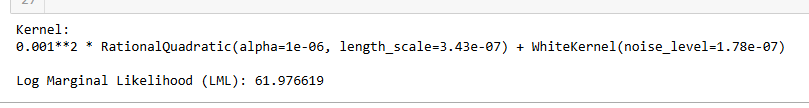

# Conclusion abou the Kernel
- Adding noise gets a better LML 
- Making the outlier smaller imporves the LML, currently divided by 1.8


### Key Parameters for Exploration ↔ Exploitation
#### kappa (UCB): Typical range ~ 1 to 5.

- Larger → more exploration (search broader).
- Smaller → more exploitation (stick to known good regions).
#### xi (EI): Typical range ~ 0.0 to 0.1.

- Larger → more exploration (prefers trying uncertain areas).
- Smaller → more exploitation (focus on improving known good spots).
#### beta (Some libraries): Similar to kappa, often 1–5.

- Controls variance impact; higher → explorative.


In [242]:
# pip install --upgrade scikit-learn


In [55]:
import numpy as np
from scipy.stats import norm
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
#pip install pymoo

# ----------------------------------------------------------------
# 1. Stochastic Mean
# ----------------------------------------------------------------

#### I will add a sigma in order to explore further 
def stochastic_mean(mu, noise_var, xi=1.0): #Param2
    """
    HEBO's stochastic mean: m_HEBO(x) = m(x) + xi * noise_var
    mu        : GP predictive mean (array)
    noise_var : GP's noise variance (scalar or array)
    xi        : Weight for noise exploration
    """
    return mu + xi * noise_var ## To be ammended so xi can be added 
                               ## depending on the weight/trade we want the ACQ function to have

# ----------------------------------------------------------------
# 2. Single-Point Acquisitions: alpha_q-EI, alpha_q-PI, alpha_q-UCB
#    (Here q=1, so no batching).
# ----------------------------------------------------------------
def alpha_ei(mu, sigma, best_so_far):
    """
    q-EI => EI; we can do a log transform if needed.
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    ei = (mu - best_so_far) * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei

def alpha_pi(mu, sigma, best_so_far):
    """
    q-PI => PI
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    pi = norm.cdf(Z)
    return pi

def alpha_ucb(mu, sigma, beta=1.8): #Param1
    """
    q-UCB => UCB
    """
    return mu + beta * sigma

# Optional: log transform for alpha_q-EI
def log_alpha_ei(mu, sigma, best_so_far):
    """
    Approx. log of EI to handle large negative Z.
    Use a piecewise approximation for Z < -6, else exact log(EI).
    """
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - best_so_far) / sigma
    # EI
    ei = (mu - best_so_far) * norm.cdf(Z) + sigma * norm.pdf(Z)
    # Approx for extreme negative Z
    if Z < -6:
        # Based on the limit in the paper
        return np.log(sigma) - 0.5 * Z**2 - np.log(Z**2 - 1) - 0.5 * np.log(2 * np.pi)
    else:
        return np.log(np.maximum(ei, 1e-16))

# ----------------------------------------------------------------
# 3. Multi-Objective MACE Setup with pymoo
#    We want to minimize [-alphaEI, -alphaPI, alphaUCB].
#    This gives a Pareto front across multiple acquisitions.
# ----------------------------------------------------------------
class MACEProblem(Problem):
    def __init__(self, gp, bounds, best_so_far, beta=2.0, xi=1.0):
        super().__init__(n_var=len(bounds), n_obj=3, xl=[b[0] for b in bounds], xu=[b[1] for b in bounds])
        self.gp = gp
        self.best_so_far = best_so_far
        self.beta = beta
        self.xi = xi

    def _evaluate(self, X, out, *args, **kwargs):
        mu, sigma = self.gp.predict(X, return_std=True)
        noise_var = getattr(self.gp.kernel_, 'noise_level', 1e-9)  # or from WhiteKernel
        # Stochastic mean
        mu_hebo = stochastic_mean(mu, noise_var, self.xi)
        # Evaluate acquisitions
        val_ei = alpha_ei(mu_hebo, sigma, self.best_so_far)   # -(EI)
        val_pi = alpha_pi(mu_hebo, sigma, self.best_so_far)   # -(PI)
        val_ucb = alpha_ucb(mu_hebo, sigma, self.beta)        # UCB
        # Convert to array [obj1, obj2, obj3]
        # Minimizing => negative for EI, PI
        out["F"] = np.column_stack([-val_ei, -val_pi, val_ucb])

def multi_objective_acquisition_mace(gp, bounds, best_so_far, beta=2.0, xi=1.0, pop_size=100, n_gen=200): #Param6 (if high dimesnion we can go up to 200 n_gen)
    """
    Solve the MACE problem with NSGA-II using pymoo.
    Returns the Pareto set of points.
    """
    problem = MACEProblem(gp, bounds, best_so_far, beta=beta, xi=xi)
    algorithm = NSGA2(pop_size=pop_size)
    res = minimize(problem, algorithm, ("n_gen", n_gen), verbose=False)
    return res.X, res.F  # Pareto solutions and their objective values


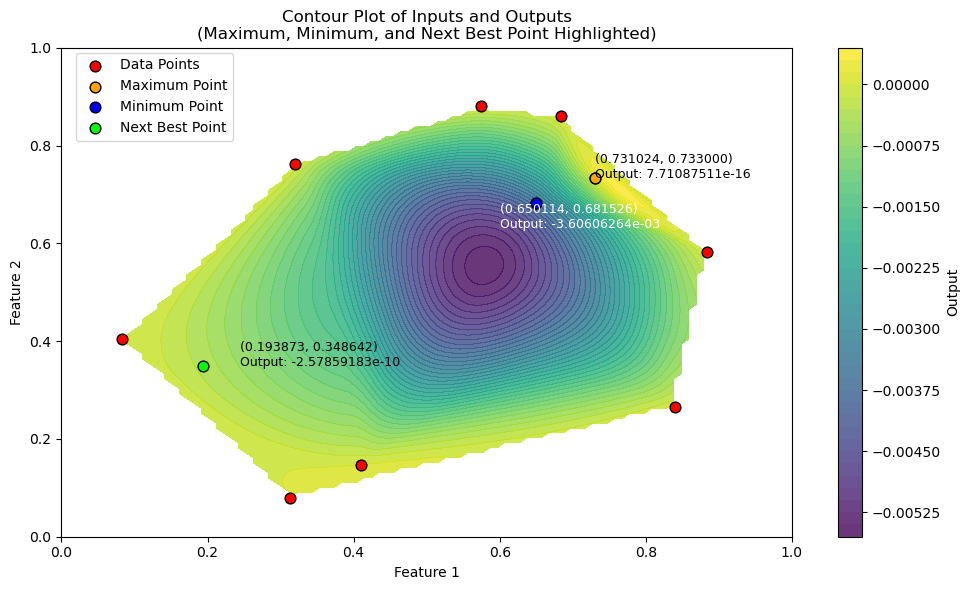

Maximum Value: 7.71087511e-16 at (x1=0.7310, x2=0.7330)
Minimum Value: -3.60606264e-03 at (x1=0.6501, x2=0.6815)
Next Best Point (WPI): -2.57859183e-10 at (x1=0.193873, x2=0.348642)


In [72]:
from scipy.optimize import minimize
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, RationalQuadratic, WhiteKernel
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm

# Weighted Probability of Improvement (WPI)
def weighted_probability_of_improvement(X, gp, current_best, w=1.0):
    mu, sigma = gp.predict(X, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    Z = (mu - current_best) / sigma
    return w * norm.cdf(Z)

# def optimize_acquisition_wpi(acquisition_func, gp, bounds, current_best, w=1.0):
#     def min_obj(X):
#         return -acquisition_func(X.reshape(1, -1), gp, current_best, w=w)
#     x0 = np.random.uniform(bounds[0][0], bounds[0][1], size=(len(bounds),))
#     res = minimize(fun=min_obj, x0=x0, bounds=bounds, method="L-BFGS-B")
#     return res.x


##-------------------
def optimize_acquisition_wpi(acquisition_func, gp, bounds, current_best, w=1.0, n_restarts=10):
    best_x = None
    best_val = float("inf")

    for _ in range(n_restarts):
        x0 = np.random.uniform(bounds[0][0], bounds[0][1], size=(len(bounds),))
        res = minimize(
            fun=lambda X: -acquisition_func(X.reshape(1, -1), gp, current_best, w=w),
            x0=x0,
            bounds=bounds,
            method="L-BFGS-B"
        )
        if res.fun < best_val:
            best_val = res.fun
            best_x = res.x

    return best_x
## to avoid getting stuck into local minimas 
# when exploration is important
# higher dimension

##-------------------

# GP model
def fit_gp_model(f1_inp, f1_out):
    kernel = (
        C(1.0, (1e-14, 1e3)) *
        RationalQuadratic(length_scale=0.00004, alpha=0.008377,
                          length_scale_bounds=(3.43e-7, 1.0),
                          alpha_bounds=(1e-6, 1))
        + WhiteKernel(noise_level=0.01, noise_level_bounds=(1e-8, 1e-1)) #Param3
    )
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
    gp.fit(f1_inp, f1_out)
    return gp

# Main Workflow
gp = fit_gp_model(f1_inp, f1_out)
bounds = [(0, 1) for _ in range(f1_inp.shape[1])]
current_best = np.max(f1_out)


w = 1.3 #Param4
next_point = optimize_acquisition_wpi(weighted_probability_of_improvement, gp, bounds, current_best, w=w)
next_z = gp.predict(next_point.reshape(1, -1))[0]

# -----------------------------------------------------Visualization---------------------------------------------------------------------
x = f1_inp[:, 0]
y = f1_inp[:, 1]
z = f1_out.ravel()
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

max_idx = np.argmax(z)
max_x, max_y, max_z = x[max_idx], y[max_idx], z[max_idx]
min_idx = np.argmin(z)
min_x, min_y, min_z = x[min_idx], y[min_idx], z[min_idx]

plt.figure(figsize=(10, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, levels=50, cmap='viridis', alpha=0.8)
plt.colorbar(label="Output")
s = 60

plt.scatter(x, y, color='red', label="Data Points", edgecolor='black', s=s)
plt.scatter(max_x, max_y, color='orange', edgecolor='black', s=s, label="Maximum Point")
plt.text(max_x, max_y, f"({max_x:.6f}, {max_y:.6f})\nOutput: {max_z:.8e}", color='black', fontsize=9)
plt.scatter(min_x, min_y, color='blue', edgecolor='black', s=s, label="Minimum Point")
plt.text(min_x - 0.05, min_y - 0.05, f"({min_x:.6f}, {min_y:.6f})\nOutput: {min_z:.8e}", color='white', fontsize=9)
plt.scatter(next_point[0], next_point[1], color='lime', edgecolor='black', s=s, label="Next Best Point")
plt.text(
    next_point[0] + 0.05, next_point[1],
    f"({next_point[0]:.6f}, {next_point[1]:.6f})\nOutput: {next_z:.8e}",
    color='black',
    fontsize=9
)

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Contour Plot of Inputs and Outputs\n(Maximum, Minimum, and Next Best Point Highlighted)")
plt.legend(loc='center left', bbox_to_anchor=(0.01, 0.9))
plt.tight_layout()
plt.show()

print(f"Maximum Value: {max_z:.8e} at (x1={max_x:.4f}, x2={max_y:.4f})")
print(f"Minimum Value: {min_z:.8e} at (x1={min_x:.4f}, x2={min_y:.4f})")
print(f"Next Best Point (WPI): {next_z:.8e} at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f})")


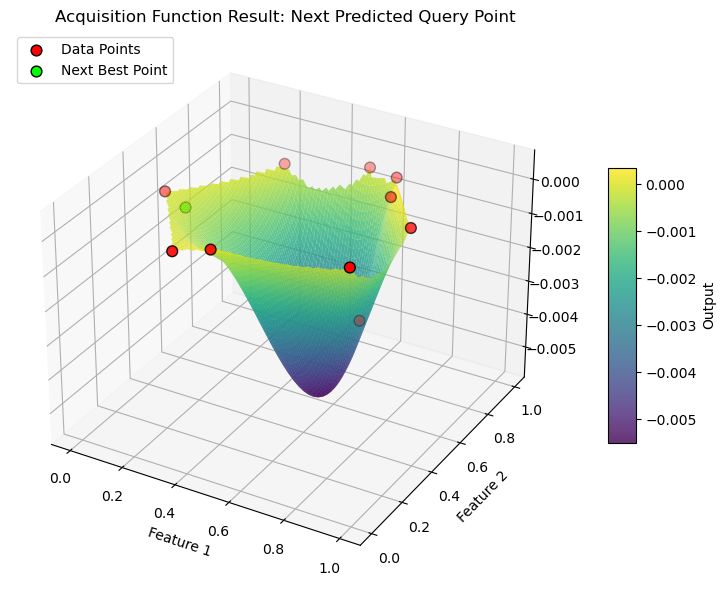

Next Best Point (WPI): at (x1=0.193873, x2=0.348642)


In [73]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # For 3D projection

fig = plt.figure(figsize=(10, 6), facecolor='white')
ax = fig.add_subplot(111, projection='3d')

# Surface with fine resolution and smoother appearance
surf = ax.plot_surface(
    grid_x, grid_y, grid_z,
    cmap='viridis', alpha=0.8, edgecolor='none', rcount=100, ccount=100
)

# Colorbar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Output")

# Scatter points
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
#ax.scatter(max_x, max_y, max_z, color='orange', edgecolor='black', s=60, label="Maximum Point")
#ax.scatter(min_x, min_y, min_z, color='blue', edgecolor='black', s=60, label="Minimum Point")
ax.scatter(next_point[0], next_point[1], next_z, color='lime', edgecolor='black', s=60, label="Next Best Point")

# Labels
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
# ax.set_zlabel("Output")
ax.set_title("Acquisition Function Result: Next Predicted Query Point", loc="center")



# Custom viewing angle and legend
ax.view_init(elev=30, azim=-60)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()
print(f"Next Best Point (WPI): at (x1={next_point[0]:.6f}, x2={next_point[1]:.6f})")



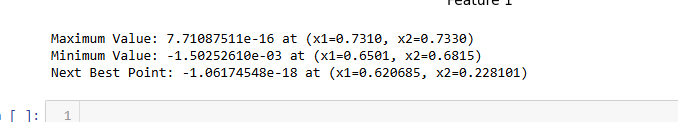

<Figure size 1500x600 with 0 Axes>

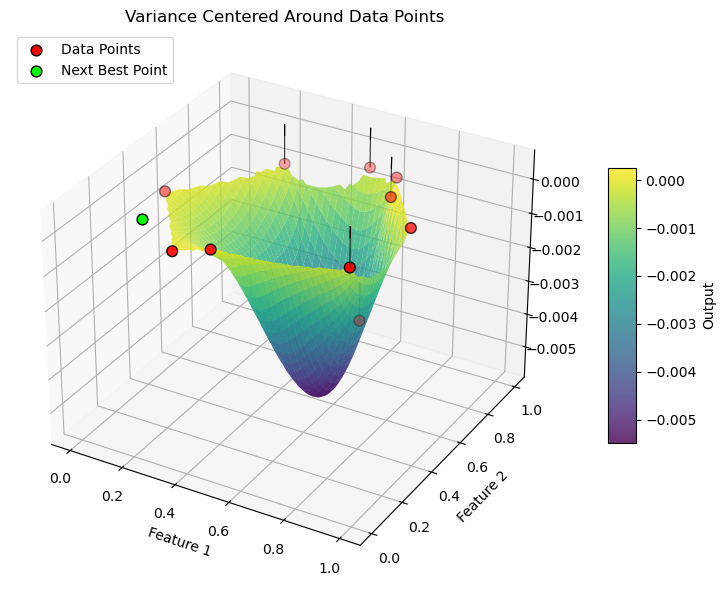

In [71]:
# Calculate variance for actual data points

plt.figure(figsize=(15, 6))
_, point_variance = gp.predict(x.reshape(-1, 2), return_std=True)

# Plot surface
fig = plt.figure(figsize=(10, 6), facecolor='white')
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(
    grid_x, grid_y, grid_z,
    cmap='viridis', alpha=0.8, edgecolor='none'
)

# Colorbar
cb = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cb.set_label("Output")

# Scatter data points with variance arrows
ax.scatter(x, y, z, color='red', edgecolor='black', s=60, label="Data Points")
for i, (xi, yi, zi, var) in enumerate(zip(x, y, z, point_variance)):
    ax.quiver(
        xi, yi, zi,  # Start point at the data point
        0, 0, var,   # Variance arrow in the Z-direction
        color="black", alpha=0.8, linewidth=0.8
    )

# Scatter the next best point
ax.scatter(next_point[0], next_point[1], next_z, color='lime', edgecolor='black', s=60, label="Next Best Point")

# Labels and title
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_title("Variance Centered Around Data Points", loc="center")

# Custom viewing angle and legend
ax.view_init(elev=30, azim=-60)
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


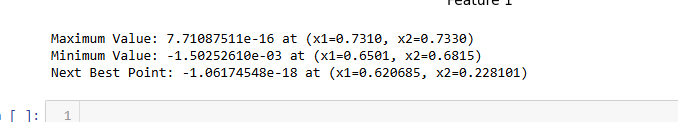

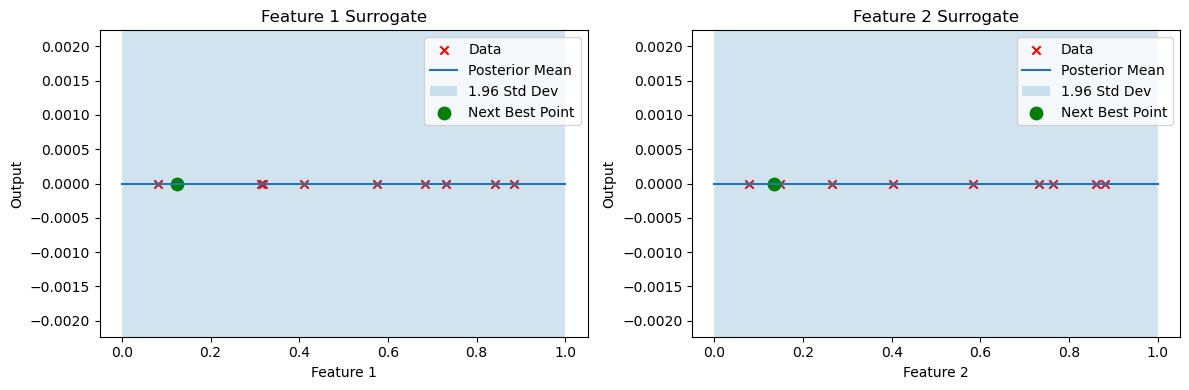

Next best point (full ND): [0.12366044 0.13563794]
Predicted mean at next best point: -2.1994511717930475e-10
Predicted std at next best point: 0.0011402932546138377


In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_gp_slices_clamped(gp, f1_inp, f1_out, next_point, beta=1.96, n_points=100):
    # Means of other features
    means_other_features = np.mean(f1_inp, axis=0)
    # Full-dim prediction of the next point
    next_mean, next_std = gp.predict(next_point.reshape(1, -1), return_std=True)
    n_features = f1_inp.shape[1]

    # Determine subplot grid
    n_cols = 2 if n_features > 1 else 1
    n_rows = int(np.ceil(n_features / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
    if n_features == 1:
        axes = np.array([axes])
    else:
        axes = axes.ravel()
    
    for i in range(n_features):
        ax = axes[i]
        
        # Build 1D grid for feature i
        grid = np.linspace(0, 1, n_points)
        X_plot = np.tile(means_other_features, (n_points, 1))
        X_plot[:, i] = grid
        
        mean_pred, std_pred = gp.predict(X_plot, return_std=True)
        
        # For each subplot, collect relevant data for robust y-lims
        # 1) Observed data on this feature
        y_data = f1_out
        x_feat = f1_inp[:, i]
        
        # 2) Posterior band
        y_pred_lower = mean_pred - beta * std_pred
        y_pred_upper = mean_pred + beta * std_pred

        # 3) Next best point on this slice
        X_next = means_other_features.copy()
        X_next[i] = next_point[i]
        y_next_dim = gp.predict(X_next.reshape(1, -1))[0]
        
        # Concatenate all for robust percentile-based clamping
        y_all = np.concatenate([
            y_data,        # actual data (all features) 
            y_pred_lower,  # model lower band
            y_pred_upper,  # model upper band
            [y_next_dim]   # next point on this slice
        ])

        # Calculate e.g. 5th and 95th percentiles as a “zoom-in” range
        y_low = np.percentile(y_all, 5)
        y_high = np.percentile(y_all, 95)

        # Plot data points
        ax.scatter(x_feat, y_data, color='red', marker='x', label='Data')
        
        # Posterior mean line
        ax.plot(grid, mean_pred, label='Posterior Mean')
        
        # Confidence band
        ax.fill_between(grid,
                        y_pred_lower,
                        y_pred_upper,
                        alpha=0.2,
                        label=f'{beta} Std Dev')
        
        # Next best point (on feature i slice)
        ax.scatter(next_point[i], y_next_dim, 
                   color='green', s=80, marker='o',
                   label='Next Best Point')

        ax.set_title(f'Feature {i+1} Surrogate')
        ax.set_xlabel(f'Feature {i+1}')
        ax.set_ylabel('Output')
        ax.legend()

        # Finally clamp the y-limits
        ax.set_ylim([y_low, y_high])

    # Hide any extra subplots
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

    print("Next best point (full ND):", next_point)
    print("Predicted mean at next best point:", next_mean[0])
    print("Predicted std at next best point:", next_std[0])

    
plot_gp_slices_clamped(gp, f1_inp, f1_out, next_point, beta=1.96, n_points=100)

# Testing Generalisation and performance 

- Above I realised the the bounds where giving me a big change in the result, so I will test the MSE and MAE, to get the best parameters, of the Kernel.


	Lower Bound	Upper Bound	Avg MSE	Avg MAE
231	3.088844e-09	63.632653	1.972000e-07	0.000264